### Softmax Regression on MNIST
#### Implementation of softmax regression (multinomial logistic regression)

#### Imports

In [2]:
import time
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

## Load the Dataset

In [4]:
BATCH_SIZE = 256
NUM_FEATURES = 784
NUM_CLASSES = 10
LEARNING_RATE = 0.1
IMAGE_H_W = 28*28
NUM_EPOCHS = 32

In [5]:
# Define MNIST training dataset
train_dataset = datasets.MNIST(root='mnist',
                train=True,
                download=True,
                transform=transforms.ToTensor())

# Define MNIST testing dataset
test_dataset = datasets.MNIST(root='mnist',
                train=False,
                transform=transforms.ToTensor())

# Download MNIST training dataset of batch size 256
train_loader = DataLoader(dataset=train_dataset,
            shuffle=True,
            batch_size=BATCH_SIZE)

# Download MNIST testing dataset of batch size 256
test_loader = DataLoader(dataset=test_dataset,
            shuffle=False,
            batch_size=BATCH_SIZE)

In [6]:
for images, labels in train_loader:
    print("Shape of feature image: ", images.shape)
    print("Shape of label image: ", labels.shape)
    break

Shape of feature image:  torch.Size([256, 1, 28, 28])
Shape of label image:  torch.Size([256])


In [7]:
for targets in test_loader:
    print(torch.tensor(targets[0]).shape)
    break

torch.Size([256, 1, 28, 28])


C:\Users\halig\AppData\Local\Temp\ipykernel_9556\2409859267.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(targets[0]).shape)


## Define, Initialise Model

In [8]:
class SoftmaxRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__() #class inheritance to ensure that the parent class is properly initialized.

        self.linear = torch.nn.Linear(num_features, num_classes) # Net inputs
        self.linear.weight.detach().zero_() # how the weight initialized
        self.linear.bias.detach().zero_()  # how the bias are initialized

    def forward(self, x):
        logits = self.linear(x) # calling the linear
        probs = F.softmax(logits, dim=1) # applying softmax non-linearity activation function
        return logits, probs

In [9]:
model = SoftmaxRegression(num_features=NUM_FEATURES, num_classes=NUM_CLASSES)

In [19]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
model.to(DEVICE)

SoftmaxRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [13]:
# Cost function
def compute_accuracy(model, data_loader):
    correct_prediction, num_examples = 0, 0

    for features, labels in data_loader:
        # Data Parallelizm if GPU is available
        features = features.view(-1, IMAGE_H_W).to(DEVICE)
        labels = labels.to(DEVICE)
        
        logits, probs = model(features)
        _, predicted_labels = torch.max(probs, 1)
        num_examples += labels.size(0)
        correct_prediction += (predicted_labels == labels).sum()

    return correct_prediction.float() / num_examples * 100

## Training on Mnist Dataset

In [14]:
import time
start_time = time.time()
epoch_costs = []
for epoch in range(NUM_EPOCHS):
    avg_cost = 0.
    for batch_idx, (features, labels) in enumerate(train_loader):

        # Data Parallelism or Load the data to device
        features = features.view(-1, IMAGE_H_W).to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward and back prop
        logits, probs = model(features)

        cost = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        cost.backward()
        avg_cost += cost 

        # Update the model parameter
        optimizer.step()

        # Logging
        if not batch_idx % 50:
           print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_dataset)//256, cost))

    with torch.set_grad_enabled(False):
        avg_cost = avg_cost/len(train_dataset)
        epoch_costs.append(avg_cost)
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader)))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/032 | Batch 000/234 | Cost: 2.3026
Epoch: 001/032 | Batch 050/234 | Cost: 0.7954
Epoch: 001/032 | Batch 100/234 | Cost: 0.5941
Epoch: 001/032 | Batch 150/234 | Cost: 0.5106
Epoch: 001/032 | Batch 200/234 | Cost: 0.4894
Epoch: 001/032 training accuracy: 87.84%
Time elapsed: 0.18 min
Epoch: 002/032 | Batch 000/234 | Cost: 0.4347
Epoch: 002/032 | Batch 050/234 | Cost: 0.4396
Epoch: 002/032 | Batch 100/234 | Cost: 0.3928
Epoch: 002/032 | Batch 150/234 | Cost: 0.4706
Epoch: 002/032 | Batch 200/234 | Cost: 0.4056
Epoch: 002/032 training accuracy: 89.38%
Time elapsed: 0.36 min
Epoch: 003/032 | Batch 000/234 | Cost: 0.3778
Epoch: 003/032 | Batch 050/234 | Cost: 0.4121
Epoch: 003/032 | Batch 100/234 | Cost: 0.3513
Epoch: 003/032 | Batch 150/234 | Cost: 0.3669
Epoch: 003/032 | Batch 200/234 | Cost: 0.3068
Epoch: 003/032 training accuracy: 89.95%
Time elapsed: 0.55 min
Epoch: 004/032 | Batch 000/234 | Cost: 0.3419
Epoch: 004/032 | Batch 050/234 | Cost: 0.4272
Epoch: 004/032 | Batch 100

## Visualizing Loss

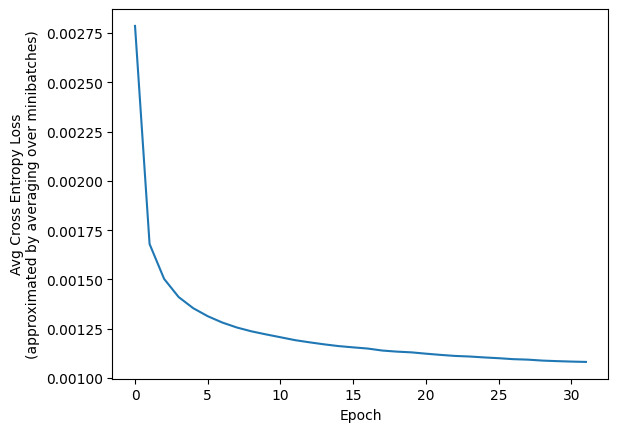

In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


plt.plot(epoch_costs)
plt.ylabel('Avg Cross Entropy Loss\n(approximated by averaging over minibatches)')
plt.xlabel('Epoch')
plt.show()

## Test Accuracy

In [17]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 92.35%


## Make predictions

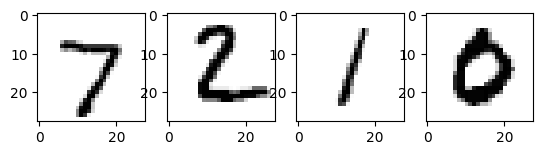

In [18]:
for features, targets in test_loader:
    break
    
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(features[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [15]:
_, predictions = model.forward(features[:4].view(-1, IMAGE_H_W).to(DEVICE))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions)

Predicted labels tensor([1, 0, 8, 4])
